# Project Goal
 
* Discover drivers of customer churn at Telco.
* Use drivers to develop a machine learning model that accurately predicts churn. 

## Imports

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings("ignore")

from scipy import stats

import env
import wrangle as w
import explore as e
#import modeling as m

## Acquire

- Data acquired from Kaggle
- It contained 7,043 rows and 22 columns before cleaning
- Each row represents a telco customer
- Each column represents a feature of the customer

## Prepare
#### Prepare Actions:

- Removed redundant or unusefull columns
- Checked for nulls in the data (there were none)
- Convert the data type of the total charges column to reflect/use the data properly
- Added Target column 'upset' indicating weather the lower rated player won the game
- Split data into train, validate and test (approx. 60/25/15), with proportions based on the Churn column

### Data Dictionary

| Feature | Definition |
|:--------|:-----------|
|Gender| The gender of the primary account holder|
|Senior Citizen| True or False, is the primary account holder 62 years or age or older|
|Partner| Yes or No, does the primary account holder have a partner in the household|
|Dependants| Yes or No, does the primary account holder have at least 1 dependent in the household|
|Tenure| The time in years the primary account holder has been a customer|
|Phone Service| Yes or No, does the primary account holder have phone service with Telco|
|Multiple Lines| Yes or No, does the primary account holder have multiple lines with Telco|
|Internet Service Type ID|  **1** (DSL), **2** (Fiber Optic), **3** (None)
|Tech Support| Yes or No, Has the client contacted tech support|
|Contract Type ID|  **1** (Month-to-Month), **2** (One-Year), **3** (Two-Year)|
|Payment Type ID| **1** (Electronic Check), **2** (Mailed Check), **3** (Automatic Bank Transfer), **4** (Credit Card)|
|Monthly Charges| Monthly bill assesed to the cusotmer|
|Total Charges| Total revenue paid by the cusotmer|
|Churn| Yes or No, has the customer stopped doing business with us|

In [3]:
# acquire & clean the data
df = w.wrangle_telco_data()

# split the data into train, validate, and test subsets
train, validate, test = w.split_my_data(df)

### A breif look at our data:

In [4]:
train.head()

,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,internet_service_type_id,tech_support,contract_type_id,payment_type_id,monthly_charges,total_charges,churn
0,Male,0,No,No,1,Yes,No,1,No,1,2,45.05,45.05,Yes
1,Male,0,Yes,No,4,Yes,Yes,2,No,1,1,100.20,420.20,Yes
2,Male,0,No,No,19,Yes,No,2,No,1,4,73.85,1424.50,Yes
3,Male,0,Yes,No,51,Yes,No,1,Yes,3,4,83.25,4089.45,No
4,Male,0,No,No,59,Yes,Yes,1,No,3,4,54.15,3116.15,No


### A summary of the charges:

In [5]:
train[['monthly_charges', 'total_charges']].describe().round(2)

,monthly_charges,total_charges
count,3943.00,3937.00
mean,64.88,2291.53
std,30.20,2279.27
min,18.55,18.80
25%,35.58,386.50
50%,70.35,1393.60
75%,89.90,3801.70
max,118.75,8684.80


## Explore

### What proportion of customers have churned?

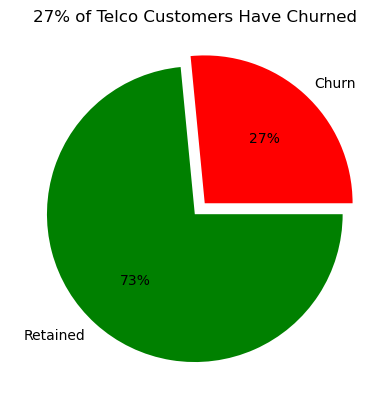

In [6]:
e.get_pie_churn(train)

    - Telco has a 73% retention rate overall

### What proportion of churned customers are senior citizens?

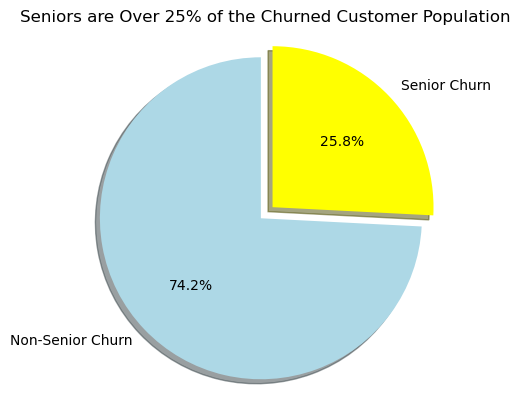

In [7]:
e.get_pie_sen_churn(train)

    - We see almost 26% of the churned customers are seniors, are they over-represented here?

### How does the proportion of churned seniors compare to the observed population?

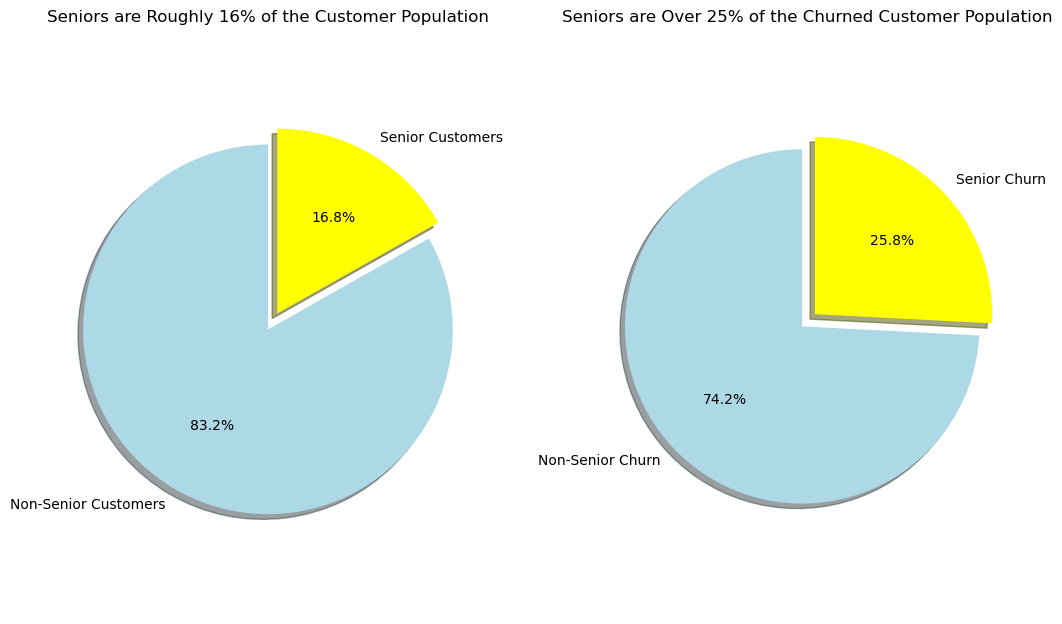

In [8]:
e.get_pie_sen_compared(train)

    - We see that the senior churn rate is disproportional to the population.

##### Lets use a chi-square test to see if Churn and Senior Citizen status are related

- I will use a confidence interval of 95%
- The resulting alpha is .05

##### Ho: 'churn' and 'senior_citizen' are independent of one another.
##### Ha: 'churn and 'senior_citizen' are related.

In [10]:
e.get_chi_senior(train)

chi2 = 81.5347
p     = 0.00000000


Technically, a p value cannot truly be 0. Statistically speaking, we can very confidently reject the null hypothesis as our evidence supports a small probability that their relationship is due to chance. Based on the p value of this calculation and the clear disproportion of churned customers being senior citizens, we can be confident that senior citizen status is a key feature we need to investigate concerning churn.

### Are seniors paying more than non-seniors?

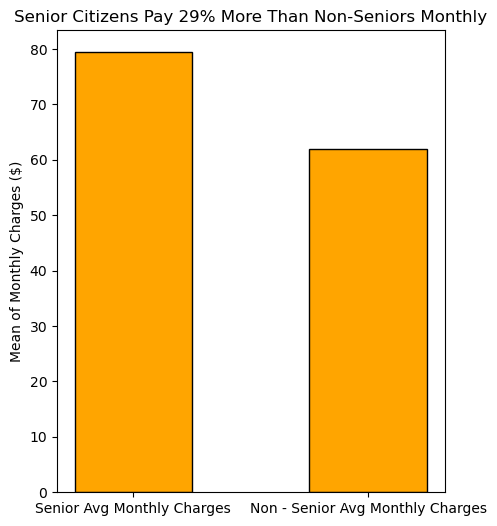

In [11]:
e.get_bar_charges(train)

    - Yes, seniors are charged aproximately 29% more monthly, but are the higher paying seniors the ones leaving?

##### Are monthy charges of senior customers who churn significantly different than senior citizens who do not churn?

I will perform an Independent t-test to calculate a tstat and p-value comparing monthly charges of seniors who churn and seniors who do not.

- I will use a confidence interval of 95%
- The resulting alpha is .05

##### H0: Monthly charges of senior customers who churn equals senior customers who don't churn. 
##### Ha: Monthly charges of senior customers who churn is not equal to senior customers who don't churn.

In [13]:
e.sen_churn_tstat(train)

t-stat = 1.0287
p     = 0.3040


Because p/2 is less than our alpha of .05, we fail to reject the null hypothesis. While senior customers are paying considerably more than non senior customers on a monthly basis, we cannot be confident that higher monthly charges is a driver of churn among senior citizen customers, as the monthly charges of seniors who churn is relatively equal to those who do not. 

### Could access to Tech Support be a factor of churn among seniors?

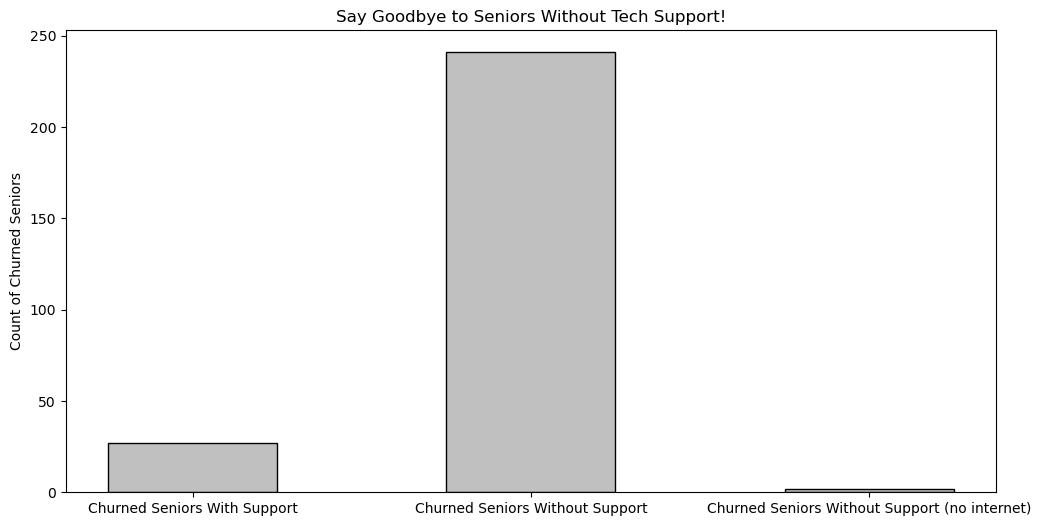

In [14]:
e.get_bar_support(train)

    - Very clearly we see that a vast majority of churned seniors did not have access to tech support

##### I will now use a chi-square test to investigate weather Churn and Tech Support are related among senior citizens.

I will use a confidence interval of 95%
The resulting alpha is .05

##### Ho: Churn and Tech Support among seniors are independent of one another.
##### Ha: Churn and Tech Support among seniors are related.

In [15]:
e.get_chi_techsupp_sen(train)

chi^2 = 71.0265
p     = 0.00000000


In a chi square test, if p < alpha, there exists some relationship between the two groups. Since our p value is much lower and close to 0, we can confidently reject the null hypothesis that churn and tech support among seniors are independent of one another among senior citizens. Based on the p-value of this calculation and the vast dispropotion of churned seniors without tech support, we can be confident this is a major driver of churn among senior citizens. 

## Exploration Summary

- 27% of customers have churned
- Senior citizens churn at a dipropotional rate compared to non-seniors
- Chi square test promotes confidence in the relationship of churn and senior citizens
- Senior citizens pay more monthly on average than non seniors 
- **Our independent t test failed to promote confidence that monthly charges is a driver in senior churn**
- Seniors without tech support churn at a vastly higher rate than those with tech support
- Our chi square test backs up this theory, showing confidence in a relationship between churn and tech support among seniors